<img src="./logo_UNSAM.jpg" align="right" width="250" /> 

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº9
#### Nicolás Sewrjugin y Sofía Gervasi


# Introducción

Existen diferentes técnicas para la eliminación del movimiento de línea de base en señales electrocardiográficas (*ECG*), una interferencia de muy baja frecuencia (típicamente $<0.5\,\text{Hz}$) que distorsiona la morfología del registro y dificulta la detección de los complejos QRS. El objetivo consiste en obtener una señal filtrada $\hat{x}(n)$, a partir de la señal contaminada $s(n)$, mediante la relación:
\begin{equation}
\hat{x}(n) = s(n) - \hat{b}(n),
\end{equation}
donde $\hat{b}(n)$ es la estimación del desplazamiento de línea de base. 

La primera técnica analizada es el filtrado de mediana, un método no lineal que reemplaza cada muestra por el valor central de una ventana ordenada. Esta propiedad lo hace especialmente eficaz para preservar transiciones abruptas como los complejos *QRS*, mientras atenúa variaciones lentas. En este trabajo, se aplica en dos etapas temporales consecutivas de $200\,\text{ms}$ y $600\,\text{ms}$, resultando en
\begin{equation}
\hat{b}(n) = \mathrm{med}_{600}\big(\mathrm{med}_{200}(s(n))\big),
\end{equation}
donde $\mathrm{med}_{t}(\cdot)$ denota el operador de mediana en una ventana de duración $t$. 

La segunda técnica emplea interpolación mediante splines cúbicos, que construyen una función suave, continua hasta la tercera derivada y ajustada a un conjunto de puntos donde la señal se considera libre de actividad eléctrica significativa (segmento *PQ*). A partir de las detecciones de cada latido, se forma el conjunto
\begin{equation}
S = \{(m_i,\, s(m_i))\}, \qquad m_i = n_i - n_0,
\end{equation}
y luego se interpola mediante una función spline cúbica que genera una señal continua muestreada a la misma frecuencia que el *ECG*:
\begin{equation}
\hat{b}(n) = \mathrm{spline}_3(S,n).
\end{equation}

Además, una vez habiendo eliminado el movimiento de línea de base de la señal, también resulta interesante el hecho de poder detectar correctamente el complejo *QRS* (es decir, los latidos), parte fundamental para el análisis del *ECG*. Para esto, se puede utilizar un filtro adaptado como una técnica adecuada, la cual consiste en un sistema diseñado para maximizar la correlación entre la señal de entrada y un patrón conocido. En el contexto del *ECG*, ese patrón corresponde a la forma típica de un complejo QRS. Cuando el filtro recibe la señal, produce un pico de salida en los instantes donde la señal se parece al patrón, permitiendo así detectar los latidos de manera robusta.



# Análisis y desarrollo



### Filtro de Mediana

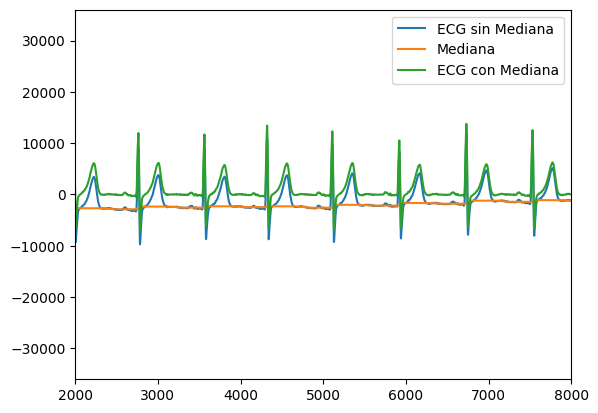

In [8]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import interpolate as inter

#ECG
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead'].flatten()
N = len(ecg_one_lead)
cant_muestras = N

ECG_med200 = signal.medfilt(ecg_one_lead, 199) #debe ser impar el kernel size pq no hay mediana de algo impar y me conviene para q el retardo sea entero (si fuera lineal)
ECG_med600 = signal.medfilt(ECG_med200, 599)

ECG_sb = ecg_one_lead-ECG_med600

plt.figure(1)
plt.plot(ecg_one_lead, label = 'ECG sin Mediana')
plt.plot(ECG_med600, label = 'Mediana')
plt.plot(ECG_sb, label = 'ECG con Mediana')
plt.xlim(2000, 8000)
plt.legend()


### Interpolación mediante Splines Cúbicos

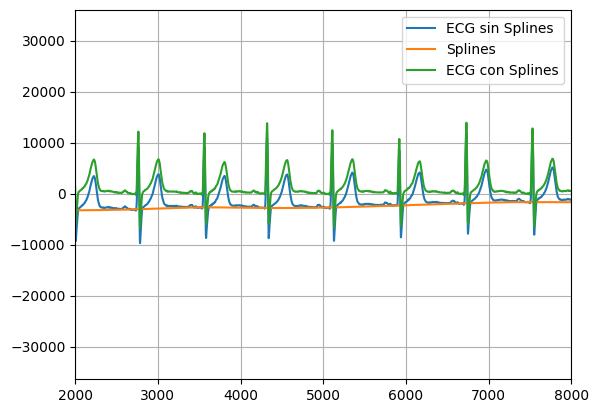

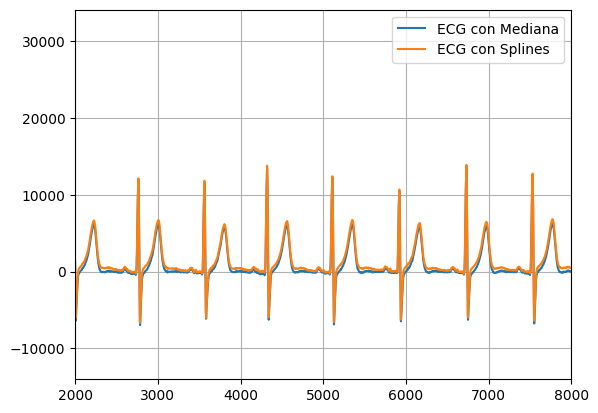

In [9]:
fs = 1000

qrs_detections = mat_struct['qrs_detections'].flatten()
n0 = int(0.08*fs)
mi = qrs_detections-n0

sm = ecg_one_lead[mi]

sc = inter.CubicSpline(mi,sm)

sb = sc(np.arange(N))

ECG_sb2 = ecg_one_lead-sb

plt.figure(2)
plt.plot(ecg_one_lead, label = 'ECG sin Splines')
plt.plot(sb, label = 'Splines')
plt.plot(ECG_sb2, label = 'ECG con Splines')
plt.xlim(2000, 8000)
plt.grid(True)
plt.legend()

plt.figure(3)
plt.plot(ecg_one_lead, label = 'ECG')
plt.plot(ECG_sb, label = 'ECG con Mediana')
plt.plot(ECG_sb2, label = 'ECG con Splines')
plt.xlim(2000, 8000)
plt.grid(True)
plt.legend()


### Filtro Adaptado

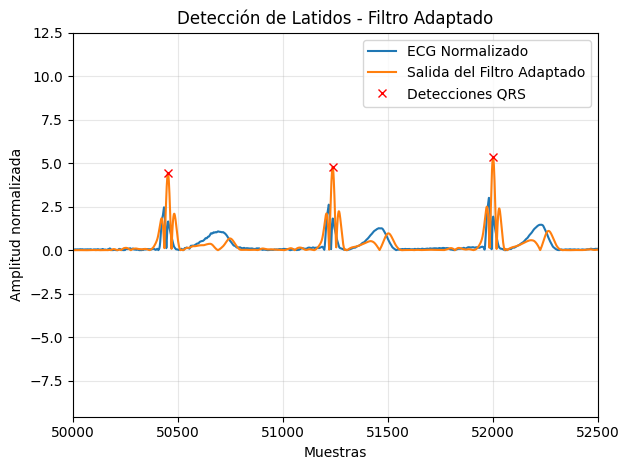

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal 
import scipy.io as sio

sio.whosmat('ECG_TP4.mat')

mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()

qrs_pattern1 = mat_struct['qrs_pattern1']  
pattern2 = qrs_pattern1.flatten() - np.mean(qrs_pattern1) 


ecg_detection = signal.lfilter(b=pattern2[::-1], a=1, x=ecg_one_lead)


ecg_detection_abs = np.abs(ecg_detection)[50:]  
ecg_detection_norm = ecg_detection_abs / np.std(ecg_detection_abs)  

qrs_detected, _ = signal.find_peaks(ecg_detection_norm, height=1, distance=300)

ecg_one_lead_abs = np.abs(ecg_one_lead)
ecg_one_lead_norm = ecg_one_lead_abs / np.std(ecg_one_lead_abs)


plt.figure(figsize=(12, 6))
plt.plot(ecg_one_lead_norm, label='ECG Normalizado')
plt.plot(ecg_detection_norm, label='Salida del Filtro Adaptado')
plt.plot(qrs_detected, ecg_detection_norm[qrs_detected], 'rx', label='Detecciones QRS')
plt.xlim(50000, 52500)
plt.xlabel('Muestras')
plt.ylabel('Amplitud normalizada')
plt.title('Detección de Latidos - Filtro Adaptado')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Conclusiones

En el caso del Filtro de Mediana y de Splines Cúbicos, al comparar las tres señales simultáneamente  se evidencia que ambos métodos logran centrar efectivamente la señal alrededor de cero, eliminando la componente de baja frecuencia asociada al movimiento de línea de base. El filtro de mediana produce una señal que mantiene una morfología muy similar a la original, preservando las proporciones y características de las distintas ondas del complejo cardíaco. En contraste, el método de splines cúbicos exhibe una sobre-amplificación ciertas componentes de la señal, particularmente en las ondas P y T. Esta amplificación diferencial sugiere que el método de splines no se limita a remover la componente de baja frecuencia, sino que introduce una distorsión no lineal que afecta selectivamente ciertas características de la señal. Un ejemplo de esta diferencia se observa en las ondas T, mientras el filtro de mediana preserva su forma y amplitud, el método de splines produce ondas T con morfología alterada. Este comportamiento sugiere que la técnica de interpolación mediante splines puede estar confundiendo componentes fisiológicas legítimas de baja frecuencia con el movimiento de línea de base que se desea eliminar, resultando en una sobre-corrección que distorsiona las características de la señal ECG.

El Filtro Adaptado funciona calculando la correlación cruzada entre la señal ECG normalizada y el patrón QRS proporcionado, produciendo en su salida un valor máximo cuando ambas formas de onda se alinean temporalmente. La operación de correlación genera picos pronunciados en las ubicaciones de los complejos QRS, mientras que durante los segmentos entre latidos la salida permanece cercana a cero debido a la baja similitud entre el patrón y estas porciones de la señal. El filtro adaptado demuestra un buen desempeño al lograr identificar correctamente los latidos mediante la ubicación de estos máximos de correlación, señalados con cruces rojas. Un aspecto a destacar, es que idealmente esperaríamos que la salida del filtro produjera un único pico estrecho para cada latido detectado, pero en la realidad se observa que alrededor de cada pico principal aparecen oscilaciones secundarias de menor amplitud. Esto ocurre porque el filtro calcula la similitud entre el patrón de referencia y cada porción de la señal mediante una ventana movil. Cuando esta ventana se encuentra perfectamente alineada con un complejo QRS, la correlación es máxima y se obtiene el pico principal. Sin embargo, en las posiciones inmediatamente anteriores y posteriores existe aún cierta similitud parcial entre el patrón y la señal, ya que partes del complejo QRS todavía se superponen con el patrón, lo que genera estas oscilaciones secundarias no deseadas.
